# Deep Learning &mdash; Assignment 4

Fourth assignment for the 2024 Deep Learning course (NWI-IMC070) of the Radboud University.

-----

**Names:** Andrew Schroeder and Fynn Gerding

**Group:** 17

-----

**Instructions:**
* Fill in your names and the name of your group.
* Answer the questions and complete the code where necessary.
* Keep your answers brief, one or two sentences is usually enough.
* Re-run the whole notebook before you submit your work.
* Save the notebook as a PDF and submit that in Brightspace together with the `.ipynb` notebook file.
* The easiest way to make a PDF of your notebook is via File > Print Preview and then use your browser's print option to print to PDF.

## Objectives

In this assignment you will
1. Experiment with convolutional neural networks
2. Train a convolutional neural network on a speech dataset
3. Investigate the effect of dropout and batch normalization
4. Define and train a residual neural network

## Required software

If you haven't done so already, you will need to install the following additional libraries:
* `torch` and `torchvision` for PyTorch,
* `python_speech_features` to compute MFCC features.

All libraries can be installed with `pip install`.

In [2]:
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import time
from scipy.io import wavfile
from IPython import display

# Fix the seed, so outputs are exactly reproducible
torch.manual_seed(12345)

# Use the GPU if available
def detect_device():
    if torch.cuda.is_available():
        return torch.device("cuda")
    elif torch.backends.mps.is_available():
        return torch.device("mps")
    else:
        return torch.device("cpu")
device = detect_device()

## 4.1 Convolution and receptive fields (9 points)

We will first define some helper functions to plot the receptive field of a node in a network.

In [3]:
def show_image(img, title=None, new_figure=True):
    if new_figure:
        plt.figure(figsize=(5, 5))
    im = plt.imshow(img, interpolation='none', aspect='equal', cmap='gray')
    ax = plt.gca();

    # plot pixel numbers and grid lines
    ax.set_xticks(np.arange(0, img.shape[1], 1))
    ax.set_yticks(np.arange(0, img.shape[0], 1))
    ax.set_xticklabels(np.arange(0, img.shape[1], 1))
    ax.set_yticklabels(np.arange(0, img.shape[0], 1))
    ax.set_xticks(np.arange(-.5, img.shape[1], 1), minor=True)
    ax.set_yticks(np.arange(-.5, img.shape[0], 1), minor=True)
    ax.grid(which='minor', color='gray', linestyle='-', linewidth=1.5)

    # hide axis outline
    for spine in ax.spines.values():
        spine.set_visible(False)

    if title is not None:
        plt.title(title)

# set all weights in the network to one,
# all biases to zero
def fill_weights_with_ones(network):
    for name, param in network.named_parameters():
        if 'weight' in name:
            param.data = torch.ones_like(param.data)
        elif 'bias' in name:
            param.data = torch.zeros_like(param.data)
    return network

def compute_receptive_field(network, input_size=(15, 15), binary=True):
    assert isinstance(network, torch.nn.Sequential), 'This only works with torch.nn.Sequential networks.'
    for layer in network:
        if not isinstance(layer, (torch.nn.Conv2d, torch.nn.AvgPool2d)):
            raise Exception('Sorry, this visualisation only works for Conv2d and AvgPool2d.')

    # initialize weights to ones, biases to zeros
    fill_weights_with_ones(network)

    # find the number of input and output channels
    input_channels = None
    output_channels = None
    for layer in network:
        if isinstance(layer, torch.nn.Conv2d):
            if input_channels is None:
                # first convolution layer
                input_channels = layer.in_channels
            output_channels = layer.out_channels
    if input_channels is None:
        input_channels = 1

    # first, we run the forward pass to compute the output shape give the input

    # PyTorch expects input shape [samples, channels, rows, columns]
    x = torch.zeros(1, input_channels, *input_size)
    x.requires_grad = True

    # forward pass: apply each layer in the network
    y = x
    y.retain_grad()
    ys = [y]
    for layer in network:
        y = layer(y)
        # keep track of the intermediate values so we can plot them later
        y.retain_grad()
        ys.append(y)

    # second, we run the backward pass to compute the receptive field

    # create gradient input: zeros everywhere, except for a single pixel
    y_grad = torch.zeros_like(y)
    # put a one somewhere in the middle of the output
    y_grad[0, 0, (y_grad.shape[2] - 1) // 2, (y_grad.shape[3] - 1) // 2] = 1

    # compute the gradients given this single one
    y.backward(y_grad)

    # receptive field is now in the gradient at each layer
    receptive_fields = []
    for y in ys:
        # the gradient for this layer shows us the receptive field
        receptive_field = y.grad
        if binary:
            receptive_field = receptive_field > 0
        receptive_fields.append(receptive_field)
    return receptive_fields

def plot_receptive_field(network, input_size=(15, 15), binary=True):
    receptive_fields = compute_receptive_field(network, input_size, binary)
    
    # plot the gradient at each layer
    plt.figure(figsize=(4 * len(receptive_fields), 4))
    for idx, receptive_field in enumerate(receptive_fields):
        plt.subplot(1, len(receptive_fields), idx + 1)
        # the last element of ys contains the output of the network
        if idx == len(receptive_fields) - 1:
            plot_title = 'output (%dx%d)' % (receptive_field.shape[2], receptive_field.shape[3])
        else:
            plot_title = 'layer %d input (%dx%d)' % (idx, receptive_field.shape[2], receptive_field.shape[3])
        # plot the image with the receptive field (sample 0, channel 0)
        show_image(receptive_field[0, 0], new_figure=False, title=plot_title)
        if not binary:
            plt.colorbar(fraction=0.047 * receptive_field.shape[0] / receptive_field.shape[1])

def receptive_field_size(network, input_size=(15, 15), binary=True):
    receptive_fields = compute_receptive_field(network, input_size, binary)
    return torch.count_nonzero(torch.flatten(receptive_fields[0][0,0]))

Using these functions, we can define a network and plot the receptive field of a pixel in the output.

**(a) Run the code to define a network with one 3×3 convolution layer and plot the images.**

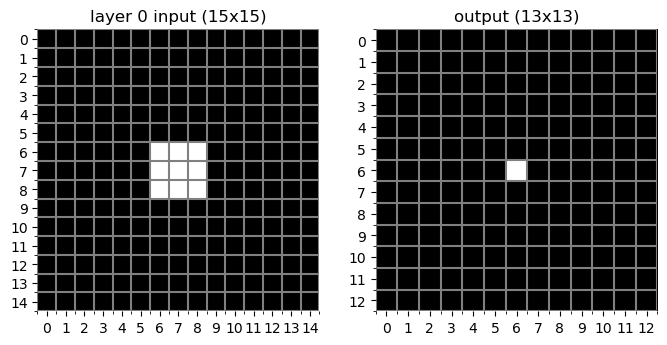

In [4]:
net = torch.nn.Sequential(
    torch.nn.Conv2d(1, 1, kernel_size=(3, 3)),
)
plot_receptive_field(net, input_size=(15, 15))

Read these images as follows:
* On the left, you see the input size of the network (here: 15 x 15 pixels) and the receptive field for one pixel in the output.
* On the right, you see the output size of the network (here: 13 x 13 pixels).

To visualize the receptive field of this network, we used the following procedure:
* We selected one pixel of the output (shown as the white pixel in the center in the image on the right).
* We computed the gradient for this pixel and plotted the gradient with respect to the input (the image on the left).
* This shows you the receptive field of the network: the output for the pixel we selected depends on these 9 pixels in the input.

**(b) Use this method to plot the receptive field of a pixel in the output of a convolution layer with a kernel size of 5×5.<span style="float:right"> (1 point)</span>**

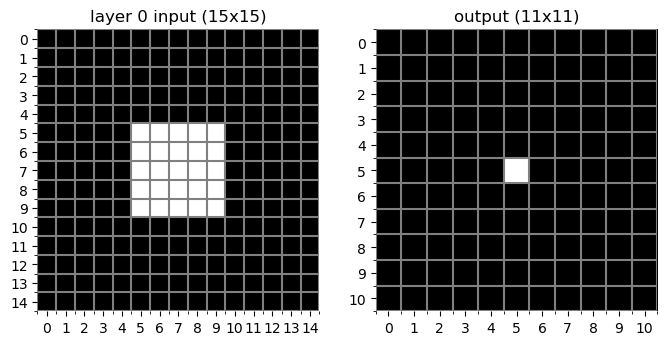

In [5]:
net = torch.nn.Sequential(
    torch.nn.Conv2d(1, 1, kernel_size=(5, 5)),
)
plot_receptive_field(net, input_size=(15, 15))

If you look at the result, you will see that two things have changed: the receptive field and the output size.

**(c) How do the receptive field size and the output size depend on the kernel size? Give a formula.<span style="float:right"> (1 point)</span>**

We will assume for the time being that the kernels are square and thus that the receptive field sizes are square.

Receptive field size: $\text{receptive\_field} = \text{kernel\_size}$

Output size: $\text{out} = \text{in}-\text{kernel\_size} + 1$

### Counting the number of parameters

In the previous question, you saw how the receptive fields of a 3×3 convolution differs from a 5×5 kernel convolution. But this is not the only difference: there is also a difference in the number of parameters in the network.

We can count the number of parameters in the network by computing the number of elements (e.g., the weights and biases in a convolution kernel) in the parameter list of the PyTorch network.

We'll define a small helper function to do this:

In [6]:
def print_parameter_count(network):
    # sum the number of elements in each parameter of the network
    count = sum([param.data.numel() for param in network.parameters()])
    print('%d parameters' % count)

**(d) Use the function to count the number of parameters for a 3×3 convolution.**

10 parameters


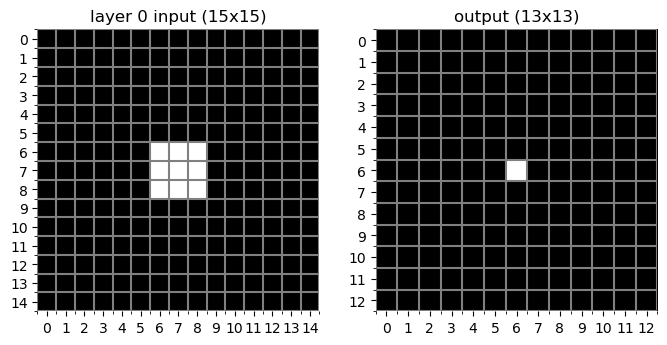

In [7]:
net = torch.nn.Sequential(
    torch.nn.Conv2d(1, 1, kernel_size=(3, 3)),
)
plot_receptive_field(net, input_size=(15, 15))
print_parameter_count(net)

**(e) Do the same to count the number of parameters for a 5×5 convolution.<span style="float:right"> (1 point)</span>**

26 parameters


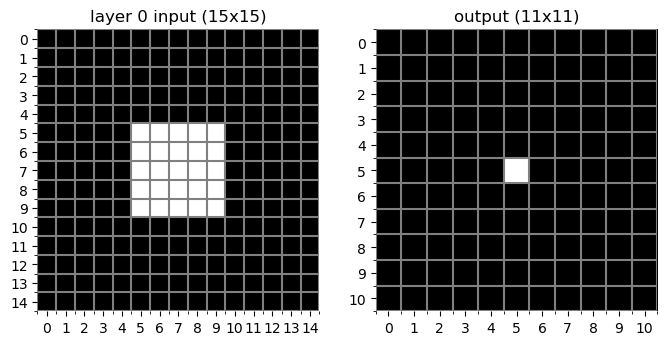

In [8]:
net = torch.nn.Sequential(
    torch.nn.Conv2d(1, 1, kernel_size=(5, 5)),
)
plot_receptive_field(net, input_size=(15, 15))
print_parameter_count(net)

**(f) Explain the results by showing how to _compute_ the number of parameters for the 3×3 and 5×5 convolutions.<span style="float:right"> (1 point)</span>**

$\text{parameters} = \text{kernel\_size}^2+1$. That is, we need one parameter per unit in the kernel, plus one additional parameter for the bias term.

For these computations we used convolution layers with one input and one output channel.

We can also compute the results for a layer with a different number of channels.

**(g) Define a network with a 5×5 convolution, 2 input channels and 3 output channels. Print the number of parameters.**

153 parameters


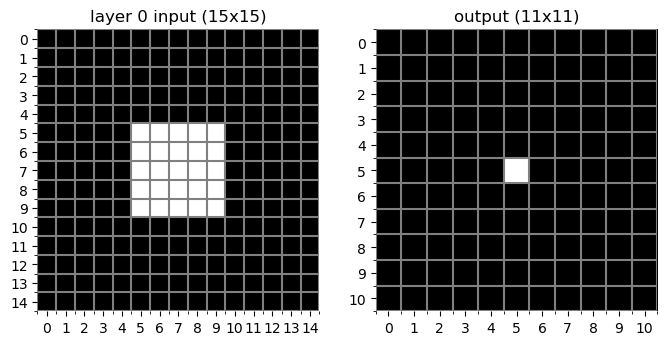

In [9]:
net = torch.nn.Sequential(
    torch.nn.Conv2d(2, 3, kernel_size=(5, 5)),
)
plot_receptive_field(net, input_size=(15, 15))
print_parameter_count(net)

**(h) Show how to compute the number of parameters for this case.<span style="float:right"> (1 point)</span>**

$\text{parameters}=(\text{kernel\_size}^2\times C_{in}\times C_{out})+C_{out}$

### Preserving the size of the input image

The PyTorch documentation for [`torch.nn.Conv2d`](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html) describes the parameters that you can use to define a convolutional layer. We will explore some of those parameters in the next questions.

In the previous plot, you may have noticed that the output (13×13 pixels) was slightly smaller than the input (15×15 pixels).

**(i) Define a network with a single 3×3 convolutional layer that produces an output that has the same size as the input.<span style="float:right"> (1 point)</span>**

Use 1 input and 1 output channel.

10 parameters


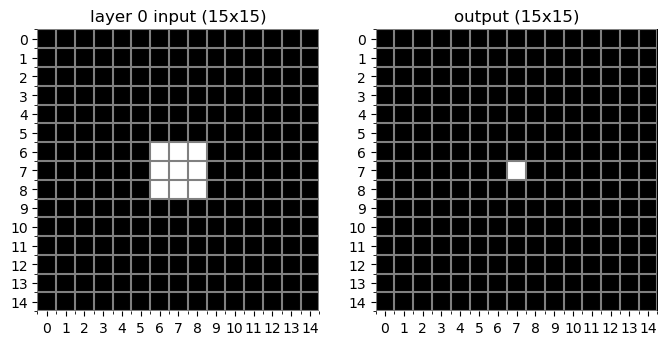

In [10]:
net = torch.nn.Sequential(
    torch.nn.Conv2d(1, 1, kernel_size=(3,3),padding="same")
)
plot_receptive_field(net, input_size=(15, 15))
print_parameter_count(net)

**(j) Define a network with a single 5×5 convolutional layer that preserves the input size.<span style="float:right"> (1 point)</span>**

26 parameters


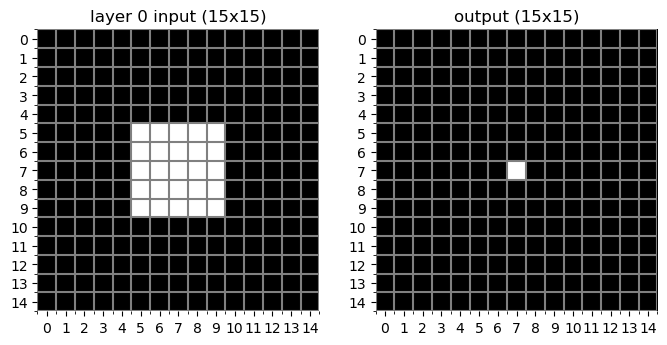

In [11]:
net = torch.nn.Sequential(
    torch.nn.Conv2d(1, 1, kernel_size=(5,5), padding="same")
)
plot_receptive_field(net, input_size=(15, 15))
print_parameter_count(net)

Play around with some other values to see how this parameter behaves.

### Multiple layers

As you have just seen, one way to increase the size of the receptive field is to use a larger convolution kernel. But another way is to use more than one convolution layer.

**(k) Define a network with two 3×3 convolutions, preserving the image size. Show the receptive field and the number of parameters.<span style="float:right"> (1 point)</span>**

For this visualisation, do not use any activation functions, and use 1 channel everywhere.

Sequential(
  (0): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (1): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=same)
)
20 parameters


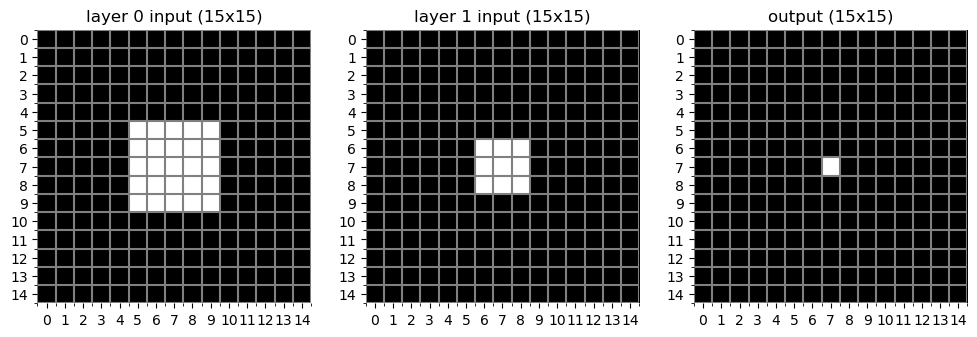

In [12]:
net = torch.nn.Sequential(
    torch.nn.Conv2d(1,1,kernel_size=(3,3), padding='same'),
    torch.nn.Conv2d(1,1,kernel_size=(3,3), padding='same')
)
print(net)
plot_receptive_field(net, input_size=(15, 15))
print_parameter_count(net)

Since we now have two layers, the visualization shows an extra image. From right to left, we have:
* Right: the output size and a single active pixel.
* Middle: the receptive field for the single output pixel between the first and second convolution.
* Left: the receptive field for the single output pixel in the input image.

We have now tried two ways to increase the receptive field size: increasing the kernel size, and using multiple layers.

**(l) Compare the number of parameters required by the two options. Which one is more parameter-efficient?<span style="float:right"> (1 point)</span>**

Recall that $\text{parameters} = \text{kernel\_size}^2+1$. When we use a single large kernel of size 5 by 5, we get 26 parameters. Now when we use two 3 by 3 kernels we get 10 parameters per kernel so 20 parameters total. Because parameter size is quadratic in $\text{kernel\_size}$ it is more parameter efficient to use multiple convolutional layers with a a smaller kernel size rather than using a larger kernel. 

## 4.2 Variations on convolution (8 points)

### Pooling

We can also increase the size of the receptive field by using a pooling layer.

**(a) Construct a network with a 3×3 convolution (preserving the input size) followed by a 2×2 average pooling. Plot the receptive field and print the number of parameters.<span style="float:right"> (1 point)</span>**

Use 1 input and 1 output channel.

Sequential(
  (0): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (1): AvgPool2d(kernel_size=2, stride=2, padding=0)
)
10 parameters


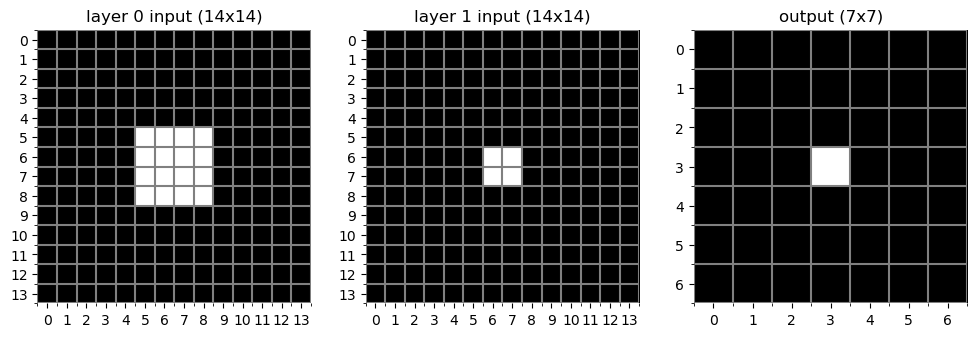

In [13]:
# TODO define a network with two 3×3 convolutions
net = torch.nn.Sequential(
    torch.nn.Conv2d(1,1,(3,3), padding="same"),
    torch.nn.AvgPool2d(2)
)
print(net)
plot_receptive_field(net, input_size=(14, 14))
print_parameter_count(net)

**(b) Explain the number of parameters in this convolution + pooling network.<span style="float:right"> (1 point)</span>**

There are $\text{parameters} = \text{kernel\_size}^2+1 = 3^2+1=10$ parameters since we are still only using a single convolutional network and the pooling layers do not have any additional parameters since we are just applying the max or average operator.

### Dilation

A third option to increase the receptive field is _dilation_.

**(c) Define a network with 3×3 convolution with dilation that preserves the input size.<span style="float:right"> (1 point)</span>**

Sequential(
  (0): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=same, dilation=(3, 3))
)
10 parameters


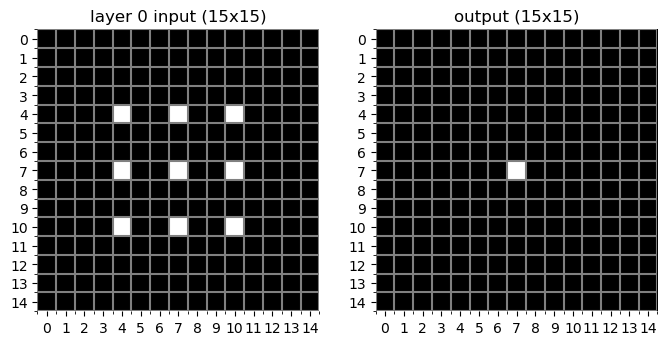

In [14]:
# TODO define a network with one 3×3 convolution with dilation
net = torch.nn.Sequential(
    torch.nn.Conv2d(1,1,kernel_size=(3,3), dilation=3, padding="same")
)
# the output should also be 15×15 pixels
print(net)
plot_receptive_field(net, input_size=(15, 15))
print_parameter_count(net)

**(d) Explain how dilation affects the receptive field.<span style="float:right"> (1 point)</span>**

Dilation expands the receptive field, however it also "dilutes" it - meaning that there are gaps in the receptive field for $\text{dilation}>1$ It effectively increases the size of the receptive field without increasing the number of parameters, the size of the kernel, or by adding additional convolutional layers. One can calculate the receptive field with the following: $\text{receptive\_field} = (\text{kernel}-1)\times(\text{dilation}-1)+\text{kernel}$

### Using strides

By default, convolution layers use a stride of 1.

**(e) Change the network to use a stride of 2 and plot the result.<span style="float:right"> (1 point)</span>**

Sequential(
  (0): Conv2d(1, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
)
10 parameters


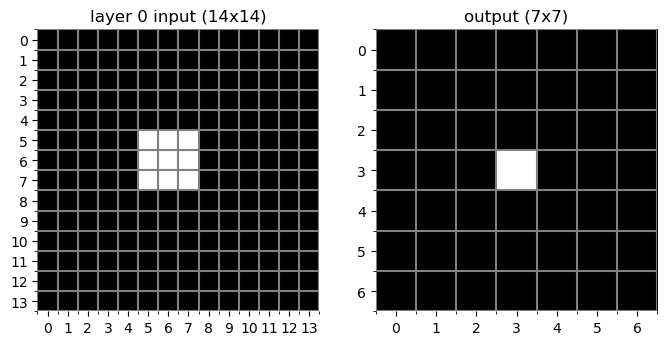

In [15]:
# TODO: Does stride effect receptive field?
net = torch.nn.Sequential(
    torch.nn.Conv2d(1, 1, kernel_size=(3, 3), padding=(1, 1), stride=2),
)
print(net)
plot_receptive_field(net, input_size=(14, 14))
print_parameter_count(net)

**(f) Explain the new output size and compare the result with that of pooling.<span style="float:right"> (1 point)</span>**

$\text{out} = \frac{\text{in}}{\text{stride}} = 14/2 = 7$. It seems that pooling results in the same output size as strides of the equivalent size. That is, for example, a $2\times2$ pooling layer would result in the same output size as using a stride of 2, all else being equal.

**(g) Explain how the stride affects the receptive field of this single convolution layer.<span style="float:right"> (1 point)</span>**

It seems that similar to pooling, stride can increase the effective receptive field by "skipping" over some of the input values and just sampling at regular intervals defined by the stride value. As a result the number of input pixels are divided by the stride to get the number of output pixels.

**(h) Explain the number of parameters for this network.<span style="float:right"> (1 point)</span>**

Answer: $\text{parameters} = \text{kernel\_size}^2+1 = 3^2+1=10$. Again, stride does not effect the number of parameters - it is determined only by the kernel size in this case. 

## 4.3 Combining layers (7 points)

As you have seen, there are multiple ways to increase the receptive field. You can make interesting combinations by stacking multiple layers.

Let's try a few ways to make networks with a large receptive field. For each of the questions in this section:

* Create a network where a pixel in the output has a 9×9 receptive field.
* Use 3 input channels and 3 output channels in every layer.
* In convolution layers, try to preserve the input size as much as possible.

**(a) Make a network with a single convolution that satisfies the above conditions.<span style="float:right"> (1 point)</span>**

Sequential(
  (0): Conv2d(3, 3, kernel_size=(9, 9), stride=(1, 1), padding=same)
)
732 parameters


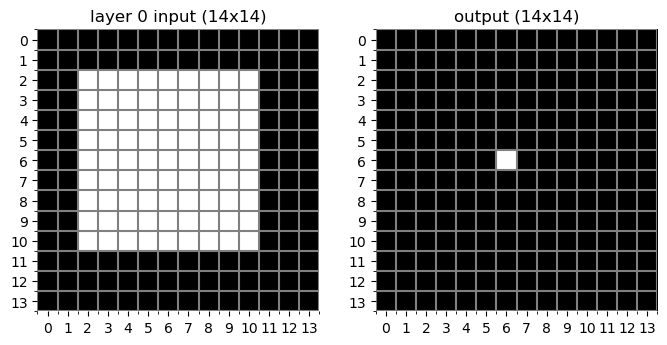

In [16]:
# TODO
# Ways to increase receptive field
# 1. larger kernel
# 2. pooling layers (multiple layers)
# 3. dilation
# 4. multiple conv layers (multiple)

# Method 1
net = torch.nn.Sequential(
    torch.nn.Conv2d(3,3,9, padding="same")
)

# Method 2: TODO: This should work as the dimensions are 9x9...
# net = torch.nn.Sequential(
#     torch.nn.Conv2d(3,3,3, padding="same", dilation=4)
# )

print(net)
plot_receptive_field(net, input_size=(14, 14))
print_parameter_count(net)
assert receptive_field_size(net) == 9*9, "Receptive field of output pixel should be a 9×9 square"

Many popular network architectures use a sequence of 3×3 convolutions.

**(b) Use only 3×3 convolutions.<span style="float:right"> (1 point)</span>**

Sequential(
  (0): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (1): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (2): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (3): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=same)
)
336 parameters


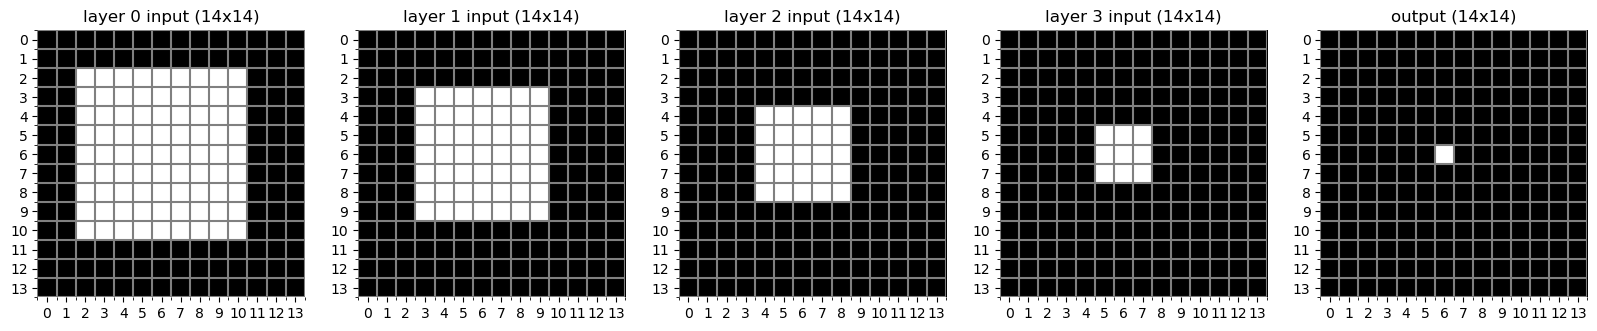

In [17]:
# TODO
net = torch.nn.Sequential(
    torch.nn.Conv2d(3,3,3,padding="same"),
    torch.nn.Conv2d(3,3,3,padding="same"),
    torch.nn.Conv2d(3,3,3,padding="same"),
    torch.nn.Conv2d(3,3,3,padding="same")
)
print(net)
plot_receptive_field(net, input_size=(14, 14))
print_parameter_count(net)
assert receptive_field_size(net) == 9*9, "Receptive field of output pixel should be a 9×9 square"

**(c) Use a 2×2 average pooling layer and a 2×2 convolution, in combination with one or more 3×3 convolutions.<span style="float:right"> (1 point)</span>**

Sequential(
  (0): Conv2d(3, 3, kernel_size=(2, 2), stride=(1, 1), padding=same)
  (1): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (2): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (3): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (4): AvgPool2d(kernel_size=2, stride=2, padding=0)
)
291 parameters


/Users/fynngerding/anaconda/envs/data-science/lib/python3.11/site-packages/torch/nn/modules/conv.py:456: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/Convolution.cpp:1032.)
  return F.conv2d(input, weight, bias, self.stride,


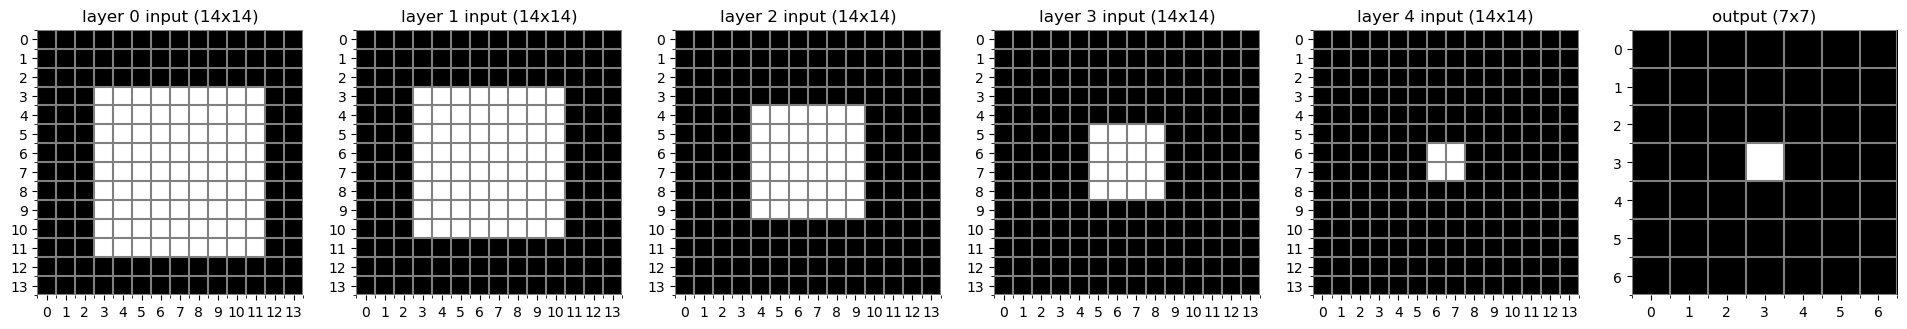

In [18]:
# TODO
net = torch.nn.Sequential(
    torch.nn.Conv2d(3,3,2,padding="same"),
    torch.nn.Conv2d(3,3,3, padding="same"),
    torch.nn.Conv2d(3,3,3, padding="same"),
    torch.nn.Conv2d(3,3,3, padding="same"),
    torch.nn.AvgPool2d(2)
)
print(net)
plot_receptive_field(net, input_size=(14, 14))
print_parameter_count(net)
assert receptive_field_size(net) == 9*9, "Receptive field of output pixel should be a 9×9 square"

**(d) Copy the previous convolution + pooling network and replace the pooling layer with a strided convolution layer.<span style="float:right"> (1 point)</span>**

Sequential(
  (0): Conv2d(3, 3, kernel_size=(2, 2), stride=(1, 1), padding=same)
  (1): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (2): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (3): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (4): Conv2d(3, 3, kernel_size=(2, 2), stride=(2, 2))
)
330 parameters


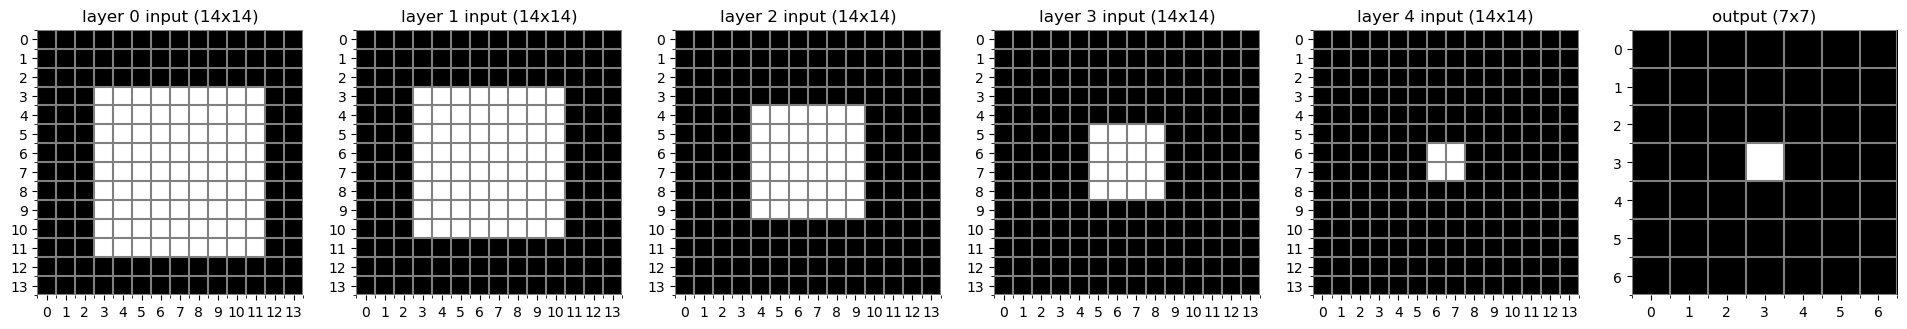

In [19]:
# TODO
net = torch.nn.Sequential(
    torch.nn.Conv2d(3,3,2,padding="same"),
    torch.nn.Conv2d(3,3,3, padding="same"),
    torch.nn.Conv2d(3,3,3, padding="same"),
    torch.nn.Conv2d(3,3,3, padding="same"),
    torch.nn.Conv2d(3,3,2, stride=2)
)
print(net)
plot_receptive_field(net, input_size=(14, 14))
print_parameter_count(net)
assert receptive_field_size(net) == 9*9, "Receptive field of output pixel should be a 9×9 square"

**(e) Construct a network with exactly two 3×3 convolutions. Use dilation to get a receptive field of 9×9 pixels.<span style="float:right"> (1 point)</span>**

Sequential(
  (0): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (1): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=same, dilation=(3, 3))
)
168 parameters


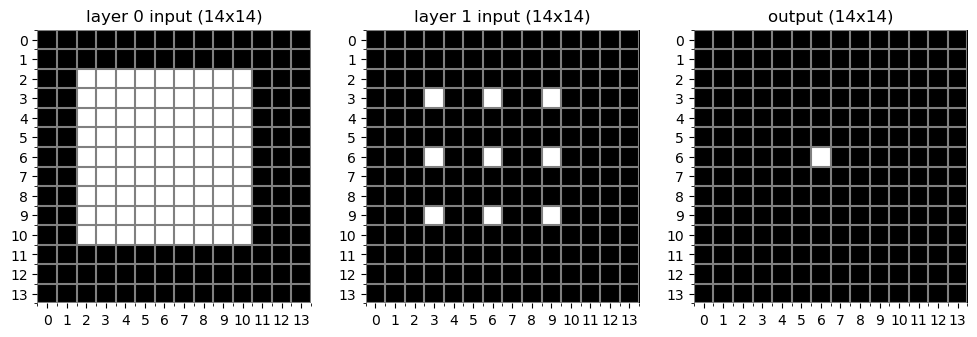

In [20]:
# TODO
net = torch.nn.Sequential(
    torch.nn.Conv2d(3,3,3, padding="same", dilation=1),
    torch.nn.Conv2d(3,3,3, padding="same", dilation=3)
)
print(net)
plot_receptive_field(net, input_size=(14, 14))
print_parameter_count(net)
assert receptive_field_size(net) == 9*9, "Receptive field of output pixel should be a 9×9 square"

**(f) For each of the methods, list the number of layers, the number of parameters, and the size of the output of the network:**

| Method                    | Layers | Parameters | Output size |
|---------------------------|--------|------------|-------------|
| One 9×9 convolution       |    1   |     732    |    14×14    | 
| Many 3×3 convolutions     |    4   |     336    |    14x14    |
| With pooling              |    5   |     291    |     7x7     |
| With strided convolution  |    5   |     330    |     7x7     |
| With dilation             |    2   |     168    |    14x14    |

**(g) Compare the methods in terms of the number of parameters.<span style="float:right"> (1 point)</span>**

We can clearly see that using large kernels as in the 9x9 convolution results in far more parameters than using a series of convolutions such as multiple 3x3 convolutions in series. We can further reduce the number of parameters by using pooling, strided convolution, or better yet, dilation which brings the number of parameters down to 168, the lowest of all. 

**(h) Compare the methods in terms of the output size. How much downsampling do they do?<span style="float:right"> (1 point)</span>**

We can see that the 9x9 convolution, many 3x3 convolutions, and with dilation all keep the output the same size as the input - 14x14. It makes sense that pooling and strided convolution when using 2 as the parameter essentially downsample the input by a factor of 2, aggregating results by either taking the average or skipping some pixels. Dilation is an interesting case because the input and output sizes remain the same, and this is because it essentially skips those convolution steps where there are pixels it has already seen before, so essentially there is no overlap of pixels in subsequent steps - perhaps this could be considered a form of downsampling?

## 4.4 Padding in very deep networks (2 points)

Without padding, the output of a convolution is smaller than the input. This limits the depth of your network.

**(a) How often can you apply a 3×3 convolution to a 15×15 input image?**

In [21]:
# find the maximum number of layers
number_of_times = 25

# create a 15×15 input
x = torch.zeros(1, 1, 15, 15)
print('input size: %d×%d' % (x.shape[2], x.shape[3]))

# create a 3×3 convolution
conv = torch.nn.Conv2d(1, 1, kernel_size=(3, 3))

for n in range(number_of_times):
    # apply another convolution
    try:
        x = conv(x)
        print('layer %d, output size: %d×%d' % (n + 1, x.shape[2], x.shape[3]))
    except RuntimeError:
        print(f'Smaller output sizes are not possible, layer {n} was the deepest possible layer without padding')
        break

input size: 15×15
layer 1, output size: 13×13
layer 2, output size: 11×11
layer 3, output size: 9×9
layer 4, output size: 7×7
layer 5, output size: 5×5
layer 6, output size: 3×3
layer 7, output size: 1×1
Smaller output sizes are not possible, layer 7 was the deepest possible layer without padding


Earlier in this assignment, you have used padding to address this problem. This seems ideal.

**(b) Copy the previous code, add some padding, and show that we can now have an infinite number of layers.**

(We are computer scientists and not mathematicians, so for the purpose of this question we'll consider 'infinite' to be equal to 25.)

In [22]:
# find the maximum number of layers
number_of_times = 25

# create a 15×15 input
x = torch.zeros(1, 1, 15, 15)
print('input size: %d×%d' % (x.shape[2], x.shape[3]))

# create a 3×3 convolution
conv = torch.nn.Conv2d(1, 1, kernel_size=(3, 3), padding="same")

for n in range(number_of_times):
    # apply another convolution
    x = conv(x)
    print('layer %d, output size: %d×%d' % (n + 1, x.shape[2], x.shape[3]))

input size: 15×15
layer 1, output size: 15×15
layer 2, output size: 15×15
layer 3, output size: 15×15
layer 4, output size: 15×15
layer 5, output size: 15×15
layer 6, output size: 15×15
layer 7, output size: 15×15
layer 8, output size: 15×15
layer 9, output size: 15×15
layer 10, output size: 15×15
layer 11, output size: 15×15
layer 12, output size: 15×15
layer 13, output size: 15×15
layer 14, output size: 15×15
layer 15, output size: 15×15
layer 16, output size: 15×15
layer 17, output size: 15×15
layer 18, output size: 15×15
layer 19, output size: 15×15
layer 20, output size: 15×15
layer 21, output size: 15×15
layer 22, output size: 15×15
layer 23, output size: 15×15
layer 24, output size: 15×15
layer 25, output size: 15×15


**(c) Does it really work like this? Have a look at the following experiment.**

* We simulate a convolution network with 25 convolution layers, with 3×3 kernels and the right amount of padding.
* We set the weights to 1/9 (so that the sum of the 3×3 kernel is equal to 1) and set the bias to zero.
* We give this network a 15×15-pixel input filled with ones.
* We plot the output of layers 5, 10, 15, 20, and 25.

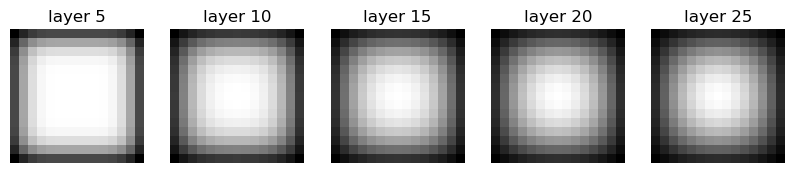

In [23]:
# create a 15×15 input filled with ones
x = torch.ones(1, 1, 15, 15)

# create a 3×3 convolution
conv = torch.nn.Conv2d(1, 1, kernel_size=(3, 3), padding=(1, 1))

# set weights to 1/9 (= sum to one), bias to zero
conv.weight.data = torch.ones_like(conv.weight.data) / 9
conv.bias.data = torch.zeros_like(conv.bias.data)

plt.figure(figsize=(10, 2))
for n in range(1, 26):
    # apply another convolution
    x = conv(x)
    # print('layer %d, output size: %d×%d' % (n + 1, x.shape[2], x.shape[3]))
    if n % 5 == 0:
        plt.subplot(1, 5, n // 5)
        plt.imshow(x[0, 0].detach().numpy(), cmap='gray')
        plt.axis('off')
        plt.title('layer %d' % n)

**(d) Explain the pattern that we see in the output of the final layers. How does this happen, and what does this mean for our very deep networks?<span style="float:right"> (2 points)</span>**

Hmm it seems that when we add padding the default padding value is 0. This means that as we go deeper into our network the borders of our input become closer and closer to 0, hence why the edges get progressively darker (black = 0). The fact that we set the kernel weights to 1/9 essentially means that we are averaging the values within each 3x3 section of the input image, thus causing a "blurring" effect to occur where the dark edges are gradually smoothed out towards the white center. This means for large networks we lose detailed spatial information and only keep the large averages in the data. This can be a negative effect if we need detailed spatial information for image segementation, for example.

## 4.5 Spoken digits dataset (4 points)

Time for some practical experiments. In the previous assignments, we have used a dataset of images (FashionMNIST), and images are also a common application for CNNs. To mix things up, in this assignment we will investigate CNNs in a completely different domain: speech recognition.

The dataset we use is the free spoken digits dataset, which can be found on https://github.com/Jakobovski/free-spoken-digit-dataset. This dataset consists of the digits 0 to 9, spoken by different speakers. The data comes as .wav files.

**(a) Use the commands below (or a similar tool) to download the dataset. You can also use `git clone` to clone the repository mentioned above.**

In [24]:
! mkdir -p free-spoken-digit-dataset
! wget -O - https://github.com/Jakobovski/free-spoken-digit-dataset/archive/refs/heads/master.tar.gz | tar xzv -C free-spoken-digit-dataset --strip-components=1

zsh:1: command not found: wget


Below is a function to load the data. We pad/truncate each sample to the same length.
The raw audio is usually stored in 16 bit integers, with a range -32768 to 32767, where 0 represents no signal. Before using the data, it should be normalized. A common approach is to make sure that the data is between -1 and 1, or that the data has zero-mean and unit-variance.  Not all of these work well on this data, so later on, if your
network doesn't seem to learn anything: try a different method to see if that works better.

**(b) Update the below code to normalize the data to a reasonable range.<span style="float:right"> (1 point)</span>**

In [104]:
samplerate = 8000
def load_waveform(file, size = 6000):
    samplerate, waveform = wavfile.read(file)
    # Take first 6000 samples from waveform. With a samplerate of 8000 samples/s that corresponds to 3/4 second
    # Pad with 0s if the file is shorter
    waveform = np.pad(waveform,(0,size))[0:size]
    waveform = (waveform - np.mean(waveform))/np.std(waveform)
    return waveform

The following code loads all .wav files in a directory, and makes it available in a pytorch dataset.

**(c) Load the data into a variable `data`.**

In [111]:
class SpokenDigits(torch.utils.data.Dataset):
    def __init__(self, data_dir):
        digits_x = []
        digits_y = []
        for file in os.listdir(data_dir):
            if file.endswith(".wav"):
                waveform = load_waveform(os.path.join(data_dir, file))
                label = int(file[0])
                digits_x.append(waveform)
                digits_y.append(label)
        # convert to torch tensors
        self.x = torch.from_numpy(np.array(digits_x, dtype=np.float32))
        # add an extra dimension to represent the "channels" (we start with 1 channel of data)
        self.x = self.x.unsqueeze(1)
        self.y = torch.from_numpy(np.array(digits_y))

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

data_dir = "free-spoken-digit-dataset/recordings"
data = SpokenDigits(data_dir)

# Check if range of values is reasonable
assert abs(torch.mean(data[0][0])) < 1e-4, "Mean of data should be close to 0"
assert torch.max(abs(data[0][0])) < 10, "Data values should not be too large"
assert torch.max(abs(data[0][0])) >= 0.9, "Data values should not be too small"

**(d) Describe the dataset: how many samples are there? How many features does each sample have? How many classes are there?<span style="float:right"> (1 point)</span>**

Note: You may compute the values, or just put in the numeric values.

In [27]:
# TODO Your answer here.
number_of_samples = len(data)
number_of_features = len(data[0][0][0])
number_of_classes = 10
print('Number of samples:', number_of_samples)
print('Number of features:', number_of_features)
print('Number of classes:', number_of_classes)

Number of samples: 3000
Number of features: 6000
Number of classes: 10


Here is code to play samples from the dataset to give you an idea what it "looks" like.

Note: If this step doesn't work in your notebook, then you can ignore it.

In [28]:
from IPython.display import Audio
def play(sample):
    print(f'Label: {sample[1]}')
    return Audio(sample[0][0].numpy(), rate=samplerate)
play(data[4])

Label: 4


Before continuing, we split the dataset into a training and a validation set.

In [29]:
train_fraction = 2/3
train_count = int(len(data) * train_fraction)
train_data, validation_data = torch.utils.data.random_split(data, [train_count, len(data) - train_count])

In [116]:
train_data[0][0].shape

torch.Size([1, 6000])

The code above uses 2/3 of the data for training.

**(e) Discuss an advantage and disadvantage of using more of the data for training.<span style="float:right"> (2 points)</span>**

The advantage of using more data for the training is that our network will have access to more samples and thus will learn more during training. The downside is that we may overfit with too much data, and we may not have sufficient data held-out to use for the validation and test sets.

## 4.6 One-dimensional convolutional neural network (8 points)

We will now define a network architecture. We will use a combination of convolutional layers and pooling.
Note that we use 1d convolution and pooling here, instead of the 2d operations used for images.

**(a) Complete the network architecture.<span style="float:right"> (2 points)</span>**

In [30]:
def build_net():
    return torch.nn.Sequential(
        torch.nn.Conv1d(1, 4, kernel_size=5),
        torch.nn.ReLU(),
        torch.nn.AvgPool1d(kernel_size=2, stride=2),
        # TODO: Add three more convolutional layers, ReLU layers and pooling layers;
        #       doubling the number of channels each time
        torch.nn.Conv1d(4, 8, kernel_size=5),
        torch.nn.ReLU(),
        torch.nn.AvgPool1d(kernel_size=2, stride=2),
        torch.nn.Conv1d(8, 16, kernel_size=5),
        torch.nn.ReLU(),
        torch.nn.AvgPool1d(kernel_size=2, stride=2),
        torch.nn.Conv1d(16, 32, kernel_size=5),
        torch.nn.ReLU(),
        torch.nn.AvgPool1d(kernel_size=2, stride=2),
        torch.nn.Flatten(),
        torch.nn.Linear(11872, 128),
        torch.nn.ReLU(),
        torch.nn.Linear(128, 64),
        torch.nn.ReLU(),
        torch.nn.Linear(64, 10))

**(b) The first fully connected layer has input dimension 11872, where does that number come from?<span style="float:right"> (1 point)</span>**

In [64]:
# Starting input size
print(f"Initial input size: {number_of_features}")

# Conv1d(1, 4, kernel_size=5)
input_size = number_of_features - 5 + 1  # 6000 -> 5996
print(f"After Conv1d(1, 4, kernel_size=5): {input_size}")

# AvgPool1d(kernel_size=2, stride=2)
input_size = input_size // 2  # 5996 -> 2998
print(f"After AvgPool1d(kernel_size=2, stride=2): {input_size}")

# Conv1d(4, 8, kernel_size=5)
input_size = input_size - 5 + 1  # 2998 -> 2994
print(f"After Conv1d(4, 8, kernel_size=5): {input_size}")

# AvgPool1d(kernel_size=2, stride=2)
input_size = input_size // 2  # 2994 -> 1497
print(f"After AvgPool1d(kernel_size=2, stride=2): {input_size}")

# Conv1d(8, 16, kernel_size=5)
input_size = input_size - 5 + 1  # 1497 -> 1493
print(f"After Conv1d(8, 16, kernel_size=5): {input_size}")

# AvgPool1d(kernel_size=2, stride=2)
input_size = input_size // 2  # 1493 -> 746
print(f"After AvgPool1d(kernel_size=2, stride=2): {input_size}")

# Conv1d(16, 32, kernel_size=5)
input_size = input_size - 5 + 1  # 746 -> 742
print(f"After Conv1d(16, 32, kernel_size=5): {input_size}")

# AvgPool1d(kernel_size=2, stride=2)
input_size = input_size // 2  # 742 -> 371
print(f"After AvgPool1d(kernel_size=2, stride=2): {input_size}")

# Final size after Flattening (32 channels)
final_size = 32 * input_size  # 32 * 371 = 11872
print(f"Final size after flattening: {final_size}")


Initial input size: 6000
After Conv1d(1, 4, kernel_size=5): 5996
After AvgPool1d(kernel_size=2, stride=2): 2998
After Conv1d(4, 8, kernel_size=5): 2994
After AvgPool1d(kernel_size=2, stride=2): 1497
After Conv1d(8, 16, kernel_size=5): 1493
After AvgPool1d(kernel_size=2, stride=2): 746
After Conv1d(16, 32, kernel_size=5): 742
After AvgPool1d(kernel_size=2, stride=2): 371
Final size after flattening: 11872


Formula for convolution:
$$\text{output_dim} = \frac{\text{input_dim} - \text{kernel_size} + 2 * \text{padding}}{\text{stride}} + 1$$

Formula for average pooling:
$$\text{output_dim} = \frac{\text{input_dim} - \text{kernel_size}}{\text{stride}} + 1$$

Hint: think about how (valid) convolutional layers and pooling layers with stride affect the size of the data.

**(c) How many parameters are there in the model? I.e. the total number of weights and biases.<span style="float:right"> (1 point)</span>**

In [41]:
# TODO: Compute the number of parameters
# Hint: use net.parameters() and param.nelement()
net = build_net()
total = 0
for i, param in enumerate(net.parameters()):
    print(f'Parameter index {i}: Parameter count: {param.nelement()}')
    total += param.nelement()
print(f'Total number of parameters: {total}')

Parameter index 0: Parameter count: 20
Parameter index 1: Parameter count: 4
Parameter index 2: Parameter count: 160
Parameter index 3: Parameter count: 8
Parameter index 4: Parameter count: 640
Parameter index 5: Parameter count: 16
Parameter index 6: Parameter count: 2560
Parameter index 7: Parameter count: 32
Parameter index 8: Parameter count: 1519616
Parameter index 9: Parameter count: 128
Parameter index 10: Parameter count: 8192
Parameter index 11: Parameter count: 64
Parameter index 12: Parameter count: 640
Parameter index 13: Parameter count: 10
Total number of parameters: 1532090


**(d) Suppose that instead of using convolutions, we had used only fully connected layers, while keeping the number of features on each hidden layer the same. How many parameters would be needed in that case approximately?<span style="float:right"> (1 point)</span>**

In [74]:
nr_layers = 4

#                         weights      biases
#                            ↓           ↓
# parameters_per_layer = features^2 + features 

total = (number_of_features*(number_of_features+1)) * nr_layers

print(f'Total parameters when using {nr_layers} fully connected layers before reducing to output dim: {total}')

total_rest = number_of_features* (128+1) + 128 * (64+1) + 64 * (10+1)

final = total + total_rest
      
print(f'Total parameters when using {nr_layers} fully connected layers and then fully connected layers (features->128->64->10):\n{total} + {total_rest} = {final}')


Total parameters when using 4 fully connected layers before reducing to output dim: 144024000
Total parameters when using 4 fully connected layers and then fully connected layers (features->128->64->10):
144024000 + 783024 = 144807024


We will once again need evaluation code and a training loop.
The code below should be familiar from previous assignments.

In [42]:
def accuracy(pred_y, true_y):
    correct = pred_y.argmax(dim=1) == true_y
    return int(correct.sum()) / len(true_y)

class Metrics:
    """Accumulate mean values of one or more metrics."""
    def __init__(self, n):
        self.count = 0
        self.sum = (0,) * n
    def add(self, count, *values):
        self.count += count
        self.sum = tuple(s + count * v for s,v in zip(self.sum,values))
    def mean(self):
        return tuple(s / self.count for s in self.sum)

def evaluate(net, test_data, batch_size=1000, loss_function=torch.nn.CrossEntropyLoss(), device=device):
    """
    Evaluate a model on the given dataset.
    Return loss, accuracy
    """
    # Note: we can use a large batch size for efficiency, it doesn't matter for the computed loss or accuracy
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)
    with torch.no_grad():
        net.eval()
        metrics = Metrics(2)
        for x, y in test_loader:
            x = x.to(device)
            y = y.to(device)
            pred_y = net(x)
            loss = loss_function(pred_y, y)
            acc = accuracy(pred_y, y)
            metrics.add(len(y), loss.item(), acc)
        return metrics.mean()

In [43]:
class Plotter:
    """For plotting data in animation."""
    # Based on d2l.Animator
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        """Defined in :numref:`sec_utils`"""
        # Incrementally plot multiple lines
        if legend is None:
            legend = []
        self.fig, self.axes = plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # Use a function to capture arguments
        def config_axes():
            axis = self.axes[0]
            axis.set_xlabel(xlabel), axis.set_ylabel(ylabel)
            axis.set_xscale(xscale), axis.set_yscale(yscale)
            axis.set_xlim(xlim),     axis.set_ylim(ylim)
            if legend:
                axis.legend(legend)
            axis.grid()
        self.config_axes = config_axes
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # Add multiple data points into the figure
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

In [44]:
def train(net, train_data, validation_data, num_epochs, lr,
          batch_size=64, optimizer=torch.optim.Adam, device=device):
    """
    Train a network on the given training data.
    After every epoch compute validation loss and accuracy.
    """
    net.to(device)
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
    num_batches = len(train_loader)
    optimizer = optimizer(net.parameters(), lr=lr)
    loss_function = torch.nn.CrossEntropyLoss()
    plotter = Plotter(xlabel='epoch', xlim=[1, num_epochs],
                      legend=['train loss', 'train acc', 'val loss', 'val acc'])
    start_time = time.time()
    for epoch in range(num_epochs):
        # Sum of training loss, sum of training accuracy, no. of examples
        net.train()
        metrics = Metrics(2)
        for i, (x, y) in enumerate(train_loader):
            #timer.start()
            optimizer.zero_grad()
            x = x.to(device)
            y = y.to(device)
            pred_y = net(x)
            loss = loss_function(pred_y, y)
            loss.backward()
            optimizer.step()
            with torch.no_grad():
                acc = accuracy(pred_y, y)
                metrics.add(len(y), loss.item(), acc)
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                train_loss, train_acc = metrics.mean()
                plotter.add(epoch + (i + 1) / num_batches, (train_loss, train_acc, None, None))
        val_loss, val_acc = evaluate(net, validation_data, loss_function=loss_function, device=device)
        plotter.add(epoch + 1, (None, None, val_loss, val_acc))
    train_loss, train_acc = metrics.mean()
    train_time = time.time() - start_time
    print(f'train loss {train_loss:.3f}, train acc {train_acc:.3f}, '
          f'val loss {val_loss:.3f}, val acc {val_acc:.3f}')
    print(f'{metrics.count * num_epochs / train_time:.1f} examples/sec '
          f'on {str(device)}')

The FashionMNIST dataset that we used before has 60000 training examples, of which we used only 1000.
When using the entire FashionMNIST dataset, around 10 epochs are needed to train a convolutional neural network.
How large is our training set this time? How would this affect the number of epochs that we need?

**(e) How many epochs do you think are needed?<span style="float:right"> (1 point)</span>**

In [59]:
lr, num_epochs = 0.0001, 100

**(f) Now train the network.**

train loss 0.141, train acc 0.964, val loss 1.129, val acc 0.684
3211.0 examples/sec on mps


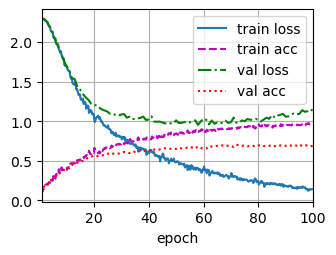

In [60]:
train(build_net(), train_data, validation_data, num_epochs=num_epochs, lr=lr)

**(g) Did the training converge?<span style="float:right"> (2 point)</span>**

**If the training has not converged, maybe you need to change the number of epochs and/or the learning rate.**

Hint: This is a non-trivial problem, so your network might take some time to
learn. Don't give up too quickly, it might take 50-100 epochs before you
see any significant changes in the loss curves.

TODO: Document the runs that you have performed and thir results in the table below.

| Experiment                | epochs | lr     | train accuracy | val. accuracy | converged? |
|---------------------------|--------|--------|----------------|---------------|------------|
| experiment 1              | 900    | 0.001  | 1              | 0.65          | yes/no     |
| experiment 2              | 200    | 0.0001 | 1              | 0.7           | overfitting|
| experiment 3              | 100    | 0.00005| 0.75           | 0.55          | no         |
| experiment 4              | 250    | 0.00005| 0.99           | 0.69          | yes, overf.|
| experiment 5              | 150    | 0.00003| 0.96           | 0.65          | no         |
| experiment 6              | 250    | 0.00004| 0.99           | 0.68          | overfitting|
| experiment 7              | 300    | 0.0001 | 1              | 0.72          | overfitting|
| experiment 8              | 100    | 0.0001 | 0.96           | 0.68          | yes, early stopping (manually)|

## 4.7 Questions and evaluation (6 points)

**(a) Does the network look like it is overfitting or underfitting? Explain how see this.<span style="float:right"> (1 point)</span>**

**Underfitting** can be seen if the learning rate is very low. The training (and validation) accuracy only increase very slowly, might not even converge. Also, the training (and validation loss) decline only very slowly.

**Overfitting** can be seen if the learning rate is too high. The training accuracy climbs to 1 very rapidly, but the validation accuracy declines after an initial improvement. Noticeably, the training loss declines very fast and remains low, while the validation loss will increase again after an initial drop.

If the learning rate and the episode count is high (about 0.001 and 300+ respectively), overfittign can be seen. The lower the learning rate, the longer it takes before that happens. Underfitting happens when the learning rate was too low (around 0.00005) and the episode count too low (abut 100).

**(b) Is what we have here a good classifier? Could it be used in a realistic application? Motivate your answer.<span style="float:right"> (1 point)</span>**

The highest accuracy that we were able to achieve on the validation set was about 0.72. For practical applications that might not be enough. Especially, if the actual application has a more diverse data distribution than the data samples in the fashion_mnist data set. If they are 'out of distribution', extrapolation might not be possible.

**(c) Do you think there is enough training data compared to the dimensions of the data and the number of parameters? Motivate your answer.<span style="float:right"> (1 point)</span>**

Considering the high amount of parameters and that for 10 categories, if evenly balanced, there are only (3000/10 =) 300 samples each, the training data might be insufficient to reach a robust and good performance. An additional consieration to support this could be that each sample has 6000 features, which are quite hard to make sense of.

**(d) How could the classifier be improved? Give at least 2 suggestions.<span style="float:right"> (1 point)</span>**

A larger data sample or data augmentaion could help to reach a better performance.

Additionally, as there is a perspective of time in audio data, networks with recurrent connections might help.

Other considerations could be to use dropout, regularisation, batch normalisation, cooling learning rates, early stopping or trying different network sizes (depth and hidden layer sizes)

**(e) The free spoken digits datasets has recordings from several different speakers. Is the validation set accuracy a good measure of how well the trained network would perform for recognizing digits spoken by a new, unknown speaker? And if not, how could that be tested instead?<span style="float:right"> (2 points)</span>**

Depending on the diversity within the speakers and how much the network relies on having seen characteristics of some speaker before in the train set, the network might not keep the validation accuracy on an entirely new set of samples from a completely unknown speaker. It would be a better idea to hold out the samples from some speakers entirely to make the generalisation to samples in the validation set more representative of real applications.

## 4.8 Variations (8 points)

One way in which the training might be improved is with dropout or with batch normalization.

**(a) Make a copy of the network architecture from 4.6a below, and add dropout.<span style="float:right"> (1 point)</span>**

In [76]:
lr, num_epochs = 0.0001, 300

train loss 0.039, train acc 0.987, val loss 1.847, val acc 0.719
2850.0 examples/sec on mps


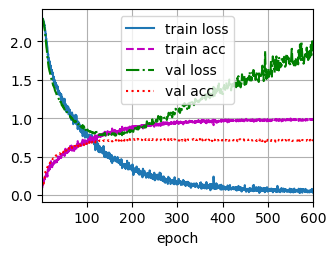

In [77]:
def build_net_dropout():
    return torch.nn.Sequential(
        torch.nn.Conv1d(1, 4, kernel_size=5),
        torch.nn.ReLU(),
        torch.nn.AvgPool1d(kernel_size=2, stride=2),
        torch.nn.Conv1d(4, 8, kernel_size=5),
        torch.nn.ReLU(),
        torch.nn.AvgPool1d(kernel_size=2, stride=2),
        torch.nn.Conv1d(8, 16, kernel_size=5),
        torch.nn.ReLU(),
        torch.nn.AvgPool1d(kernel_size=2, stride=2),
        torch.nn.Conv1d(16, 32, kernel_size=5),
        torch.nn.ReLU(),
        torch.nn.AvgPool1d(kernel_size=2, stride=2),
        torch.nn.Flatten(),
        torch.nn.Linear(11872, 128),
        torch.nn.ReLU(),
        torch.nn.Dropout(p=0.3),
        torch.nn.Linear(128, 64),
        torch.nn.ReLU(),
        torch.nn.Dropout(p=0.3),
        torch.nn.Linear(64, 10))

train(build_net_dropout(), train_data, validation_data, num_epochs=2*num_epochs, lr=lr)

**(b) How does dropout change the results? Does this match what you saw on the simple network last week?<span style="float:right"> (1 point)</span>**

The choices of parameters that worked best in the network without dropout (`lr=0.0001` and `num_epochs=300`) lead to significant overfitting. Now, when applying dropout, the training and validation loss reach very similar performances and overfitting is reduced, but not completely mitigated when choosing for `torch.nn.Dropout(p=0.3)`.

Generally, this matches what we learned about dropout last week: as a more robust data representation is enforced, overfitting is reduced.

**(c) Make a copy of the original network architecture, and add batch normalization to all convolutional and linear layers.<span style="float:right"> (1 point)</span>**

train loss 0.000, train acc 1.000, val loss 0.715, val acc 0.811
2557.6 examples/sec on mps


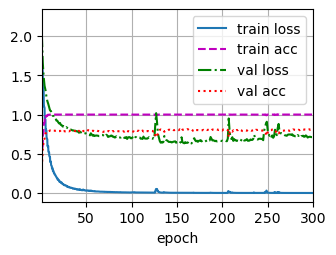

In [78]:
def build_net_batchnorm():
        return torch.nn.Sequential(
        torch.nn.Conv1d(1, 4, kernel_size=5),
        torch.nn.BatchNorm1d(4),
        torch.nn.ReLU(),
        torch.nn.AvgPool1d(kernel_size=2, stride=2),
        
        torch.nn.Conv1d(4, 8, kernel_size=5),
        torch.nn.BatchNorm1d(8),
        torch.nn.ReLU(),
        torch.nn.AvgPool1d(kernel_size=2, stride=2),
        
        torch.nn.Conv1d(8, 16, kernel_size=5),
        torch.nn.BatchNorm1d(16),
        torch.nn.ReLU(),
        torch.nn.AvgPool1d(kernel_size=2, stride=2),
        
        torch.nn.Conv1d(16, 32, kernel_size=5),
        torch.nn.BatchNorm1d(32),
        torch.nn.ReLU(),
        torch.nn.AvgPool1d(kernel_size=2, stride=2),
        
        torch.nn.Flatten(),
        
        torch.nn.Linear(11872, 128),
        torch.nn.BatchNorm1d(128),
        torch.nn.ReLU(),
        
        torch.nn.Linear(128, 64),
        torch.nn.BatchNorm1d(64),
        torch.nn.ReLU(),
        
        torch.nn.Linear(64, 10)
    )

train(build_net_batchnorm(), train_data, validation_data, num_epochs=num_epochs, lr=lr)

**(d) How does batch normalization change the results? Does this match what you saw on the simple network last week?<span style="float:right"> (1 point)</span>**

With batch normalisation in place, it seems like overfitting is completely fixed. The performance of the network is stabelised and the final validation performance is improved with `val_acc = 0.811`.

Last week, we learned that batch normalisation helps generalisation and speeds up the training by regularising and stabelising the convergence.

### Residual network

We can also try to use a residual network.

Pytorch does not expose a general purpose block for residual connections.
If you look at the [source code for ResNet vision model](https://pytorch.org/vision/0.8/_modules/torchvision/models/resnet.html), you will find the following definitions (slightly simplified):

In [79]:
# From https://pytorch.org/vision/0.8/_modules/torchvision/models/resnet.html
# (simplified)

def conv3x3(in_channels, out_channels, stride=1):
    """3x3 convolution with padding"""
    return torch.nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=stride, bias=False)

def conv1x1(in_channels, out_channels, stride=1):
    """1x1 convolution, used for downsampling"""
    return torch.nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False)

class ResidualBlock2d(torch.nn.Module):
    def __init__(self, in_channels, channels, stride=1, downsample=None, norm_layer=None):
        super(ResidualBlock2d, self).__init__()
        if norm_layer is None:
            norm_layer = torch.nn.BatchNorm1d
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(in_channels, channels, stride)
        self.bn1 = norm_layer(channels)
        self.relu = torch.nn.ReLU(inplace=True)
        self.conv2 = conv3x3(channels, channels)
        self.bn2 = norm_layer(channels)
        if downsample is True:
            downsample = torch.nn.Sequential(conv1x1(in_channels, channels), norm_layer(channels))
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

**(e) Copy the `ResidualBlock2d` module below, and adapt it for 1d convolutions. Use a kernel size of 5 for the convolution layers.<span style="float:right"> (2 points)</span>**

Use residual blocks each containing two convolutional layers.

In [96]:
def conv1x5(in_channels, out_channels, stride=1):
    """1D convolution with kernel size 5 and padding"""
    return torch.nn.Conv1d(in_channels, out_channels, kernel_size=5, padding=2, stride=stride, bias=False)

def conv1x1(in_channels, out_channels, stride=1):
    """1x1 convolution, used for downsampling"""
    return torch.nn.Conv1d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False)

class ResidualBlock1d(torch.nn.Module):
    def __init__(self, in_channels, channels, stride=1, downsample=None, norm_layer=None):
        super(ResidualBlock1d, self).__init__()
        if norm_layer is None:
            norm_layer = torch.nn.BatchNorm1d
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x5(in_channels, channels, stride)
        self.bn1 = norm_layer(channels)
        self.relu = torch.nn.ReLU(inplace=True)
        self.conv2 = conv1x5(channels, channels)
        self.bn2 = norm_layer(channels)
        if downsample is True:
            downsample = torch.nn.Sequential(conv1x1(in_channels, channels), norm_layer(channels))
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

**(f) Make a copy of the network architecture from 4.6a, and replace the convolutions with residual blocks.<span style="float:right"> (1 point)</span>**

train loss 0.000, train acc 1.000, val loss 0.470, val acc 0.908
1836.6 examples/sec on mps


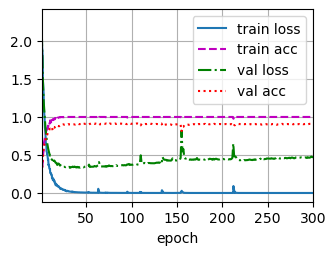

In [98]:
def build_resnet():
    return torch.nn.Sequential(
        ResidualBlock1d(1, 4, downsample = True),
        torch.nn.ReLU(),
        torch.nn.AvgPool1d(kernel_size=2, stride=2),
        ResidualBlock1d(4, 8, downsample = True),
        torch.nn.ReLU(),
        torch.nn.AvgPool1d(kernel_size=2, stride=2),
        ResidualBlock1d(8, 16, downsample = True),
        torch.nn.ReLU(),
        torch.nn.AvgPool1d(kernel_size=2, stride=2),
        ResidualBlock1d(16, 32, downsample = True),
        torch.nn.ReLU(),
        torch.nn.AvgPool1d(kernel_size=2, stride=2),
        torch.nn.Flatten(),
        torch.nn.Linear(12000, 128),
        torch.nn.ReLU(),
        torch.nn.Linear(128, 64),
        torch.nn.ReLU(),
        torch.nn.Linear(64, 10))


resnet = build_resnet()
train(resnet, train_data, validation_data, num_epochs, lr=lr)

**(g) How do residual connections change the results?<span style="float:right"> (1 point)</span>**

The addition of residual connections allows the model to reach `val_acc = 0.9` and more stable learning curves. This makes sense, as now time series information can be incorperated more meaningfully.

## 4.9 Feature extraction (5 points)

Given enough training data a deep neural network can learn to extract features from raw data like audio and images. However, in some cases it is still necessary to do manual feature extraction, in particular when working with smaller datasets like this one. For speech recognition, a popular class of features are [MFCCs](https://en.wikipedia.org/wiki/Mel-frequency_cepstrum).

Here is code to extract these features. You will need to install the `python_speech_features` first.

In [101]:
from python_speech_features import mfcc

def load_waveform_mfcc(file, size = 6000):
    samplerate, waveform = wavfile.read(file)
    waveform = np.pad(waveform,(0,size))[0:size] / 32768
    return np.transpose(mfcc(waveform, samplerate))

**(a) Implement a variation of the dataset that uses these features.<span style="float:right"> (2 points)</span>**

In [113]:
class SpokenDigitsMFCC(torch.utils.data.Dataset):
    def __init__(self, data_dir):
        digits_x = []
        digits_y = []
        for file in os.listdir(data_dir):
            if file.endswith(".wav"):
                waveform = load_waveform_mfcc(os.path.join(data_dir, file))
                label = int(file[0])
                digits_x.append(waveform)
                digits_y.append(label)
        # convert to torch tensors
        self.x = torch.from_numpy(np.array(digits_x, dtype=np.float32))
        self.y = torch.from_numpy(np.array(digits_y))

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

data_mfcc = SpokenDigitsMFCC(data_dir)
train_count_mfcc = int(len(data_mfcc) * train_fraction)
train_data_mfcc, validation_data_mfcc = torch.utils.data.random_split(data_mfcc, [train_count_mfcc, len(data_mfcc)-train_count_mfcc])
assert train_data_mfcc[0][0].shape == torch.Size([13,74]), "There is something wrong with the SpokenDigitsMFCC dataset"

The MFCC features will have 13 channels instead of 1 (the `unsqueeze` operation is not needed). 

**(b) Inspect the shape of the data, and define a new network architecture that accepts data with this shape.<span style="float:right"> (1 point)</span>**

In [121]:
def build_net_mfcc():
    return torch.nn.Sequential(
        torch.nn.Conv1d(13, 4, kernel_size=5),
        torch.nn.ReLU(),
        torch.nn.AvgPool1d(kernel_size=2, stride=2),
        torch.nn.Conv1d(4, 8, kernel_size=5),
        torch.nn.ReLU(),
        torch.nn.AvgPool1d(kernel_size=2, stride=2),
        torch.nn.Conv1d(8, 16, kernel_size=5),
        torch.nn.ReLU(),
        torch.nn.AvgPool1d(kernel_size=2, stride=2),
        torch.nn.Conv1d(16, 32, kernel_size=5),
        torch.nn.ReLU(),
        # Removing pooling and dimension reduction layers, as input shape was smaller initially.
        # torch.nn.AvgPool1d(kernel_size=2, stride=2),
        torch.nn.Flatten(),
        # torch.nn.Linear(96, 128),
        # torch.nn.ReLU(),
        # torch.nn.Linear(128, 64),
        # torch.nn.ReLU(),
        torch.nn.Linear(32, 10))

**(c) Train the network with the MFCC features.<span style="float:right"> (1 point)</span>**

train loss 0.113, train acc 0.963, val loss 0.306, val acc 0.916
3964.8 examples/sec on mps


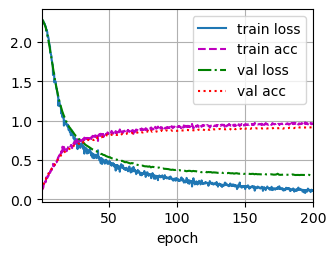

In [122]:
net = build_net_mfcc()
train(net, train_data_mfcc, validation_data_mfcc, num_epochs=200, lr=0.0001)

**(d) What would be needed to get a fully neural network approach to work as well as MFCC features?<span style="float:right"> (1 point)</span>**

Instead of using MFCCs, you could use a network architecture that learns the equivalent of a "filter bank" based on the frequency spectrum (FFT) of the signal. This would essentially allow the neural network to learn the weights of certain frequency ranges, not relying on human-engineered features anymore.

## The end

Well done! Please double check the instructions at the top before you submit your results.

*This assignment has 57 points.*
<span style="float:right;color:#aaa;font-size:10px;"> Version 3e03fe7 / 2024-09-24</span>